In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
from scipy.stats import chi2

In [2]:
#importing data
file_path = 'involved_markers_hebrew.csv'
involved_markers_hebrew = pd.read_csv(file_path)
data = involved_markers_hebrew

In [3]:
#data functions
def filtered_data(data, column):
    data_filtered = data.copy()
    data_filtered.sort_values(column)
    data_filtered.drop_duplicates(subset = column, keep = 'first', inplace = True)
    return data_filtered
    
def road_section(data, section_no):
    road_section = (data['road_segment_id']) == int(section_no)
    data_section = data[road_section]
    return data_section
def road_type(data,type_no):
    type_no = (data['road_type']) == int(type_no)
    data_road = data[type_no]
    return data_road
def road_street(street_no):
    road_street = (data['street1']) == int(street_no)
    data_street = data[road_street]
    return data_street

def data_years(data,start_year, end_year):
    data_years = (data['accident_year'] >= int(start_year)) & (data['accident_year'] <= int(end_year))
    return data[data_years]

def data_fatal(data):
    data_fatal = data[data['accident_severity'] == 1]
    return data_fatal

def fatal_road_section(section_no):
    road_section = (data_fatal['road_segment_id']) == int(section_no)
    data_fatal_section = data_fatal[road_section]
    return data_fatal_section

In [4]:
#creating different values for variables

'''1==Private car, 2==Truck, 3==Motorcycle, 4==Bus, 5==Cab, 6==Other, 7==Tractor, 8==Bicycle, 9==Train, 10==Electric bicycle \ scooter'''
data['involve_vehicle_type'] = data['involve_vehicle_type'].replace(to_replace = {1:1,2:2,3:2,4:2,5:2,6:2,7:2,8:3,9:3,10:3,11:4,12:5,13:6,14:7,15:8,16:9,17:6,18:4,19:3,20:3,21:10,22:10,23:10,24:2,25:2})

'''1==day light, 2==night light, 3==night no sight, 4==night, 5==twilight'''
data['road_light'] = data['road_light'].replace(to_replace = {1:1,2:3,3:2,4:3,5:3,6:4,7:3,8:3,9:3,10:5,11:1})

data['injury_severity'] =data['injury_severity'].replace(to_replace={1:3,2:2,3:1}).astype('category')

data['medical_type'] = data['medical_type'].replace(to_replace={9:0}).astype('category')

data['speed_limit'] =data['speed_limit'].replace(to_replace={0:0, 1:50, 2:60, 3:70, 4:80, 5:90, 6:100, 7:110, 8:120})

data['road_width'] = data['road_width'].replace(to_replace={0:0, 1:5, 2:7, 3:10.5, 4:14, 5:20})

data['engine_volume_hebrew'] = data['engine_volume_hebrew'].astype('category')

In [5]:
#creating unique data for markers analysis (reduces from 1897266 to 771638 [duplicates = 1125628])
data_filtered = filtered_data(data, 'provider_and_id')

In [6]:
#datat for accident severity harsh & fatal
data_fatal = data_fatal(data)
data_filtered_fatal = filtered_data(data_fatal, 'provider_and_id')

road section is between sdei trumot and mitzpe shalem
part of road 90
this road section is around 115 km

In [7]:
data_4 = road_type(data, 4)
data_filtered_4 = road_type(data_filtered, 4)

In [8]:
#create different data frames by road section and road type for involved
#road_segment_name: כניסה למצפה שלם - צומת שדי תרומות
data_900810 = road_section(data_4, 900810)

road_section_drop_4 = data_4.road_segment_id != (900810)
data_4 = data_4[road_section_drop_4]

In [9]:
#create different data filtered frames by road section and road type for markers
#road_segment_name: כניסה למצפה שלם - צומת שדי תרומות
data_filtered_900810 = road_section(data_filtered_4, 900810)

road_section_drop_4 = data_filtered_4.road_segment_id != (900810)
data_filtered_4 = data_filtered_4[road_section_drop_4]

In [ ]:
#Junctions on road 900810
'''
data_3 = road_type(data, 3)
data_filtered_3 = road_type(data_filtered, 3)

data_3_900810 = road_section(data_3, 900810)

road_section_drop_3 = data_3.road_segment_id != (900810)
data_3 = data_3[road_section_drop_3]'''

'''data_filtered_3_900810 = road_section(data_filtered_3, 900810)

road_section_drop_3 = data_filtered_3.road_segment_id != (900810)
data_filtered_3 = data_filtered_3[road_section_drop_3]'''

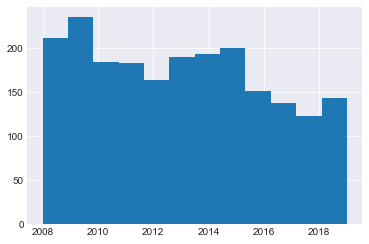

In [35]:
#presenting histogram for examining the difference between years
data_900810['accident_year'].hist(bins = 12, range =(2008, 2019))

In [108]:
'''
function to check for every category if there are less accidents over the years
*please notice this isn't a statistic test, there's still a possibility the difference is big enough for reporting 
input: data and column name(str)
returns dataframe of Boolean, True means the number of accidents declined over the years in that category 
''' 
def year_diff(data, column):
    #creating data for each period
    data_08_10 = data_years(data, 2008, 2010)
    data_11_13 = data_years(data, 2011, 2013)
    data_14_16 = data_years(data, 2014, 2016)
    data_17_19 = data_years(data, 2017, 2019)
    #caculating the differences between 4 periods (weights added)
    return (((data_11_13.groupby(column).size()- data_08_10.groupby(column).size()) /
             ((data_11_13.groupby(column).size()+ data_08_10.groupby(column).size())/2))*0.15).round(2) + (((data_14_16.groupby(column).size()- data_11_13.groupby(column).size()) /
     ((data_14_16.groupby(column).size()+ data_11_13.groupby(column).size())/2))*0.25).round(2) +(((data_17_19.groupby(column).size()- data_14_16.groupby(column).size()) /
     ((data_17_19.groupby(column).size()+ data_14_16.groupby(column).size())/2))*0.6).round(2) <=  - 0.25

#define the proper test type for each variable (changes should be made for variable)

'license_acquiring_date' can be used with 'year' to caculate the driver's years of experience
'road1' \ 'road_segment_number' count of accidents can be normlized by ספירות תנועה https://teunot.cbs.gov.il/niturtnuaenterprise/
'age_group' can be transformed to a continuous variable

data preparing:

        ['location_accuracy']
        ['road_type']
        ['road1']
        ['road2']
        ['road_segment_id']
        ['road_segment_number']
        ['road_segment_name']
        ['accident_yishuv_symbol']
        ['street1']
        ['street2']
        ['non_urban_intersection']
        ['geom']
        ['accident_district']


chi square:

    ['involve_vehicle_type']
    '''1==Private car, 2==Truck, 3==Motorcycle, 4==Bus, 5==Cab, 6==Other, 7==Tractor, 8==Bicycle, 9==Train, 10==Electric bicycle \ scooter'''
    (.replace(to_replace {1:1,2:2,3:2,4:2,5:2,6:2,7:2,8:3,9:3,10:3,11:4,12:5,13:6,14:7,15:8,16:9,17:6,18:4,19:3,20:3,21:10,22:10,23:10,24:2,25:2})) 
    ['safety_measures']
    ['involve_yishuv_symbol']
    ['injury_severity']
    ['injured_position']
    ['population_type']
    ['involve_home_district']
    ['release_dest']
    ['car_id']
    ['involve_id']
    ['accident_month']
    ['accident_type']
    ['accident_severity']
    ['road_shape']
    ['day_type'] = data['day_type'].replace(
    ['one_lane'] 
    ['multi_lane']
    ['road_intactness']
    ['road_sign']
    ['road_light']
    '''1==day light, 2==night light, 3==night no sight, 4==night, 5==twilight'''
    (.replace(to_replace({1:1,2:3,3:2,4:3,5:3,6:4,7:3,8:3,9:3,10:5,11:1}))
    ['road_control']
    ['weather']
    ['road_surface']
    ['didnt_cross']
    ['cross_mode']
    ['cross_location']
    ['day_in_week']
    ['accident_hour']
    ['driving_directions']
    ['vehicle_status']
    ['vehicle_attribution']
    ['seats']
    ['vehicle_damage']

fisher:

        ['sex']
        ['hospital_time']
        ['safety_measures_use'] (drop 3==Unknown)
        ['late_deceased']
        ['cross_direction']
        ['day_night']
        ['traffic_light']
        
T Test:

        ['injury_severity'] (.replace(to_replace {1:3,2:2,3:1}).astype('category'))
        ['medical_type'] (.replace(to_replace {9:0}).astype('category'))
        ['accident_year']
        ['speed_limit'](.replace(to_replace {0:0, 1:50, 2:60, 3:70, 4:80, 5:90, 6:100, 7:110, 8:120}))
        ['road_width'](.replace(to_replace {0:0, 1:5, 2:7, 3:10.5, 4:14, 5:20}))
        ['engine_volume_hebrew'](.astype('category'))
        ['manufacturing_year']
        ['total_weight_hebrew']
        


In [166]:
chi_markers = [
    'accident_month',
    'accident_type',
    'accident_severity',
    'road_shape',
    'day_type',
    'one_lane', 
    'multi_lane',
    'road_intactness',
    'road_sign',
    'road_light',
    'road_control',
    'weather',
    'road_surface',
    'km',
    'day_in_week',
    'accident_hour',
    'driving_directions',
    'vehicle_status',
    'vehicle_attribution',
    'seats',
    'vehicle_damage',
    'traffic_light'] 

chi_involve = [
    'sex',
    'late_deceased',
    'cross_direction',
    'involve_vehicle_type',
    'safety_measures',
    'injury_severity',
    'injured_position',
    'population_type',
    'involve_home_district',
    'release_dest',
    'safety_measures_use', 
    'involve_id',
    'car_id',
    'didnt_cross',
    'cross_mode',
    'cross_location',
    'medical_type',
    'engine_volume',
    'manufacturing_year',
    'total_weight']

In [109]:
'''
function to implement chi square 
input: data X 2(df) and column name(str)
if significant
returns dataframe of both
'''
def chi_test(data1, data2, column):
    #df for data1
    df1 = data1.groupby(column).size()
    df = pd.DataFrame(df1)
    df_idx = df.reset_index(inplace = False)
    df.columns =['column1']
    #df for data2
    df2 = data2.groupby(column).size()
    table = pd.DataFrame(df2)
    df_idx = table.reset_index(inplace = False)
    #combining both df
    df.insert(1,'column2',table)
    df = df.fillna(value = 0)

    #finding critical value
    from scipy.stats import chi2
    significance = 0.01
    p = 1 - significance
    dof = stats.chi2_contingency(df)[2]
    critical_value = chi2.ppf(p, dof)
    #comparing chi and significance values 
    if (int(stats.chi2_contingency(df, correction=True, lambda_="pearson")[1].round(2)) - significance) <= 0.05:
        if int(stats.chi2_contingency(df, correction=True, lambda_="pearson")[0].round(2)) - critical_value >= 0.1:
            return df
        else:
            return None 

In [110]:
'''
function to find chi square source of significance
input:df from chi_test function
if df is not None
returns table of diff between obs and exp precents, and index of the biggest difference
'''
def chi_sig(df):
    if df is not None:
        obs = df.copy()
        obs.reset_index(inplace = True)
        #creating sums
        sum_column1 = sum(obs['column1'])
        sum_column2 = sum(obs['column2'])
        #creating precents for obs
        obs['column1_per'] = obs['column1'].apply(lambda x: pd.Series((x/sum_column1*100), index = ['column1_per']))
        obs['column2_per'] = obs['column2'].apply(lambda x: pd.Series((x/sum_column2*100), index = ['column2_per']))
        #creating precents for exp
        exp = pd.DataFrame(stats.chi2_contingency(df, correction=True, lambda_="pearson")[3][:,0:2].round(2))
        exp['column1_per'] = exp[0].apply(lambda x: pd.Series((x/sum_column1*100), index = ['column1_per']))
        exp['column2_per'] = exp[1].apply(lambda x: pd.Series((x/sum_column2*100), index = ['column1_per']))

        return(obs.iloc[:, 3:5] - exp.iloc[:, 2:4]) , (obs.iloc[:, 3:5] - exp.iloc[:, 2:4]).idxmax()
    else:
        return None

In [13]:
#implementing chi test for chi_markers
chi_markers_sig = []
for i in chi_markers:
    df = chi_test(data_filtered_4, data_filtered_900810, i)
    if df is not None:
        chi_markers_sig.append(i)
        print(i)
        print(df)
        print(chi_sig(df))

accident_type
               column1  column2
accident_type                  
1                 2306     30.0
2                12603     97.0
3                70830    129.0
4                10231     32.0
5                 4084     82.0
6                  246      1.0
7                  508      2.0
8                11607     62.0
9                 2603     67.0
10                4925    166.0
11                5473     50.0
12                1334      6.0
13                 319      1.0
14                  14      0.0
15                2283     10.0
17                 884      0.0
18                 279      2.0
19                1255     22.0
20                 198      1.0
(    column1_per  column2_per
0     -0.012600     2.188158
1     -0.018404     3.196053
2      0.210082   -36.482895
3      0.020275    -3.521053
4     -0.044059     7.651316
5      0.000311    -0.053947
6      0.000697    -0.121053
7      0.003644    -0.632895
8     -0.039180     6.803947
9     -0.103688    18.0

[2682 rows x 2 columns]
(      column1_per  column2_per
0        0.000723    -0.588652
1        0.000270    -0.219858
2        0.000209    -0.170213
3        0.000279    -0.226950
4        0.000148    -0.120567
5        0.000383    -0.312057
6        0.000192    -0.156028
7        0.000139    -0.113475
8        0.000174    -0.141844
9        0.000192    -0.156028
10       0.003363    -2.737589
11       0.000497    -0.404255
12       0.000227    -0.184397
13       0.000139    -0.113475
14       0.000157    -0.127660
15       0.000227    -0.184397
16       0.000113    -0.092199
17       0.000113    -0.092199
18       0.000139    -0.113475
19       0.000139    -0.113475
20       0.002614    -2.127660
21       0.000253    -0.205674
22       0.000200    -0.163121
23       0.000078    -0.063830
24       0.000113    -0.092199
25       0.000174    -0.141844
26       0.000148    -0.120567
27       0.000070    -0.056738
28       0.000087    -0.070922
29       0.000026    -0.021277
...           

In [14]:
#implementing year change test for chi_markers
for i in chi_markers_sig:
    print(year_diff(data_filtered_900810, i))

accident_type
1      True
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10     True
11     True
12    False
13    False
15    False
18    False
19    False
20    False
dtype: bool
accident_severity
1     True
2    False
3    False
dtype: bool
road_shape
4    False
5     True
8     True
9    False
dtype: bool
day_type
1    False
2    False
3     True
4    False
dtype: bool
one_lane
0    False
1    False
2    False
3     True
4    False
9    False
dtype: bool
multi_lane
0    False
1    False
3    False
dtype: bool
road_intactness
0    False
1    False
2    False
3    False
dtype: bool
road_sign
1    False
2    False
3    False
4     True
5    False
dtype: bool
road_light
1    False
2    False
3     True
4    False
5    False
dtype: bool
road_control
1.0    False
5.0    False
6.0    False
7.0    False
dtype: bool
weather
1     True
2     True
3    False
4    False
5    False
9    False
dtype: bool
road_surface
1    False
2     True
3    Fa

ValueError: Length of passed values is 176, index implies 0

#chi_markers significance#

accident_type
(1),2,5,(9,10,11),18
accident_severity
(1),2
road_shape
(5,8)
day_type
1,(3)
one_lane
2,(3)
multi_lane
0
road_intactness
1
road_sign
3
road_light
(3)
road_control
1,5,6
weather
(1,2)
road_surface
1,(2)
day_in_week
1,(5,6),7
accident_hour 
6,12,14,15
driving_directions 
1,2,1023
vehicle_attribution
6
vehicle_damage
3

In [169]:
#implementing chi test for chi_involve
chi_involve_sig = []
for i in chi_involve:
    df = chi_test(data_4, data_900810, i)
    if df is not None:
        chi_involve_sig.append(i)
        print(i)
        print(df)
        print(chi_sig(df))
        

sex
     column1  column2
sex                  
0.0    69429      176
1.0   190655     1406
2.0   109141      736
(   column1_per  column2_per
0     0.069944   -11.141070
1    -0.056269     8.962899
2    -0.013675     2.178171, column1_per    0
column2_per    1
dtype: int64)
cross_direction
                 column1  column2
cross_direction                  
1                    763       13
2                    774       13
9                 367689     2292
(   column1_per  column2_per
0    -0.002210     0.352028
1    -0.002191     0.349008
2     0.004401    -0.701035, column1_per    2
column2_per    0
dtype: int64)
involve_vehicle_type
                      column1  column2
involve_vehicle_type                  
1.0                    267298   1538.0
2.0                     47362    383.0
3.0                     12584     24.0
4.0                     13177    184.0
5.0                      6751     25.0
6.0                     17467    117.0
7.0                       669     13.0
8.0 

cross_mode
            column1  column2
cross_mode                  
0            366854   2290.0
1              1016     16.0
2                85      5.0
3               524      2.0
4               422      3.0
8               263      2.0
9                62      0.0
(   column1_per  column2_per
0     0.003529    -0.562123
1    -0.002589     0.412425
2    -0.001203     0.191544
3     0.000347    -0.055220
4    -0.000095     0.015099
5    -0.000095     0.015099
6     0.000106    -0.016825, column1_per    0
column2_per    1
dtype: int64)
cross_location
                column1  column2
cross_location                  
0                367319   2292.0
1                    80      3.0
2                  1378     20.0
3                   270      0.0
4                    16      0.0
9                   163      3.0
(   column1_per  column2_per
0     0.003775    -0.601381
1    -0.000672     0.106989
2    -0.003055     0.486626
3     0.000455    -0.072476
4     0.000027    -0.004314
5    -

In [172]:
#implementing year check for chi_involve
for i in chi_involve_sig:
    print(year_diff(data_filtered_900810, i))

sex
0.0    False
1.0    False
2.0    False
dtype: bool
cross_direction
1    False
2    False
9    False
dtype: bool
involve_vehicle_type
1.0    False
2.0     True
3.0    False
4.0    False
5.0    False
6.0    False
7.0    False
dtype: bool
safety_measures
1    False
2    False
3    False
4    False
5    False
dtype: bool
injury_severity
0    False
1     True
2    False
3     True
dtype: bool
injured_position
1     True
2     True
6    False
8    False
9     True
dtype: bool
population_type
1    False
2     True
3    False
4    False
dtype: bool
involve_home_district
11    False
21    False
22     True
23     True
24     True
29    False
31     True
32    False
41    False
42    False
43    False
44    False
51     True
61    False
62     True
71    False
72    False
73     True
74     True
75    False
76    False
77    False
99    False
dtype: bool
involve_id
1     False
2     False
3     False
4      True
5     False
6     False
7     False
8     False
36    False
dtype: bool
car_id
0

#chi_involve significance#

involve_vehicle_type
(2),4
safety_measures
1,4
involve_yishuv_symbol
1466
injury_severity
(1),2,(3)
injured_position
(2)
population_type
(2),4
involve_home_region
1,(2),7
involve_home_district
11,(22,23),29,76,75,(74)
involve_id
3,(4),5,6

In [15]:
'''
function to implement fisher test 
input: data X 2(df) and column name (str)
if significant
returns dataframe of both and significance
'''
def fisher_test(data1, data2, column):
    #df for data1
    df1 = data1.groupby(column).size()
    df = pd.DataFrame(df1)
    df_idx = df.reset_index(inplace = False)
    df.columns =['column1']
    #df for data2
    df2 = data2.groupby(column).size()
    table = pd.DataFrame(df2)
    df_idx = table.reset_index(inplace = False)
    #combining both df
    df.insert(1,'column2',table)

    #comparing significance values
    significance = 0.01
    if (int(stats.fisher_exact(df, alternative='greater')[1].round(2)) - significance) <= 0.01:
            return df, stats.fisher_exact(df, alternative='greater')[1].round(2)
    else:
            return None

In [16]:
'''
function to present differences of precents
input:df from fisher_test function
if df is not None
returns table of percents for both columns
'''
def fisher_sig(df):
    if df is not None:
        obs = df.copy()
        obs.reset_index(inplace = True)
        #creating sums
        sum_column1 = sum(obs['column1'])
        sum_column2 = sum(obs['column2'])
        #creating precents for obs
        obs['column1_per'] = obs['column1'].apply(lambda x: pd.Series((x/sum_column1*100), index = ['column1_per']))
        obs['column2_per'] = obs['column2'].apply(lambda x: pd.Series((x/sum_column2*100), index = ['column2_per']))

        return obs.iloc[:,3:5]
    else:
        return None

In [116]:
fisher_markers = [
    'day_night']
fisher_involve = [
    'hospital_time']

In [117]:
#implementing fisher test for fisher_markers
fisher_markers_sig = []
for i in fisher_markers:
    df = fisher_test(data_4, data_900810, i)
    if df is not None:
        fisher_markers_sig.append(i)
        print(i)
        print(df)

day_night
(           column1  column2
day_night                  
1           255910     1581
5           113316      737, 0.13)


In [118]:
#implementing year check for fisher_markers
for i in fisher_markers_sig:
    print(year_diff(data_filtered_900810, i))

day_night
1    False
5    False
dtype: bool


In [113]:
#implementing fisher test for fisher_involve
fisher_involve_sig = []
for i in fisher_involve:
    df = fisher_test(data_4, data_900810, i)
    if df is not None:
        fisher_involve_sig.append(i)
        print(i)
        print(df)

hospital_time
(               column1  column2
hospital_time                  
1.0               4672       25
2.0               9914      155, 0.0)


In [106]:
#implementing year check for fisher_involve
for i in fisher_involve_sig:
    print(year_diff(data_filtered_900810, i))

hospital_time
1.0    False
2.0     True
dtype: bool
late_deceased
1.0     True
2.0    False
dtype: bool
cross_direction
1    False
2    False
9    False
dtype: bool


In [17]:
'''
function for recognizing the distribution type
input: data X 2(df), column name(str)
returns distribution type(str)
'''
def dist_type(data1, data2, column):
    mean1 = data1.groupby([column]).size().mean()
    median1 = data1.groupby([column]).size().median()
    mean2 = data2.groupby([column]).size().mean()
    median2 = data2.groupby([column]).size().median()
    if abs((mean1 - median1)/ ((mean1 + median1)/2)) < 0.1 :
        if abs((mean2 - median2)/ ((mean2 + median2)/2)) < 0.1:
            return 'mean'
        else:
            return 'median'

In [188]:
'''
function to implement T test 
input: data X 2(df), column name(str) and data center, for normal distribution - 'mean' 
unnormal distributions and categorical - 'median'
preformes levene test for equal variance
if significant
returns dataframe of both and significance
'''
def t_test(data1, data2, column, center = 'median'):
    levene = stats.levene(data1[column] ,data2[column], center = center)
    if levene[1] < 0.01:
        equal_var = False
    else:
        equal_var = True
    return stats.ttest_ind(data1[column] ,data2[column], equal_var = equal_var)[1].round(2)

In [191]:
t_markers = [
    'accident_year',
    'speed_limit',
    'road_width'
]

t_involve = [
    'injury_severity',
    'age_group'
]

In [190]:
#implementing t test for t_markers
for i in t_markers:
    print(i)
    print(t_test(data_filtered_4, data_filtered_900810, i))

accident_year
0.57
speed_limit
0.0
road_width
0.0
age_group
0.0


In [192]:
#implementing year check for t_markers
for i in t_markers:
    print(year_diff(data_filtered_900810, i))

accident_year
2008    False
2009    False
2010    False
2011    False
2012    False
2013    False
2014    False
2015    False
2016    False
2017    False
2018    False
2019    False
dtype: bool
speed_limit
0     False
50    False
60     True
70    False
80     True
90    False
dtype: bool
road_width
0.0     False
5.0     False
7.0     False
10.5     True
14.0    False
20.0    False
dtype: bool


In [193]:
#implementing t test for t_involve
for i in t_involve:
    print(i)
    print(t_test(data_4, data_900810, i))

injury_severity
0.0
age_group
0.0


In [194]:
#implementing year check for t_involve
for i in t_involve:
    print(year_diff(data_900810, i))

injury_severity
0    False
1     True
2    False
3    False
dtype: bool
age_group
1     False
2      True
3      True
4      True
5     False
6     False
7     False
8     False
9      True
10    False
11    False
12     True
13    False
14    False
15    False
16    False
17    False
18    False
99    False
dtype: bool


In [10]:
#slide 1
'''
significant differencess were found for 2 types of collision (Front-to-side , Front to front).
focused on the collision that is more likely to happen in a two way road, front-to-side and front to front.
the folowing graphs are presenting the differences (in percents) between road 900810 to Inter-urban roads count of accident collisions.
as accident collisions are only 12% of the accidents on Inter-urban roads, they are 22% on road 900810 excluding junctions.
'''
data_filtered_900810['front_collision'] = data_filtered_900810['accident_type'].replace(to_replace = {1:1,2:2,3:1,4:1,5:2,6:1,7:1,8:1,9:1,10:1,11:1,12:1,13:1,14:1,15:1,16:1,17:1,18:1,19:1,20:1})
df1 = data_filtered_900810.groupby(['front_collision']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = False)
df.columns =['front_collision_900810']

data_filtered_4['front_collision'] = data_filtered_4['accident_type'].replace(to_replace = {1:1,2:2,3:1,4:1,5:2,6:1,7:1,8:1,9:1,10:1,11:1,12:1,13:1,14:1,15:1,16:1,17:1,18:1,19:1,20:1})
df2 = data_filtered_4.groupby(['front_collision']).size()
table = pd.DataFrame(df2)
df_idx = table.reset_index(inplace = False)
df.insert(1,'front_collision_4',table)
print('graph 1, 2')
df

graph 1, 2


,front_collision_900810,front_collision_4
front_collision,,
1,536,115295
2,160,16687


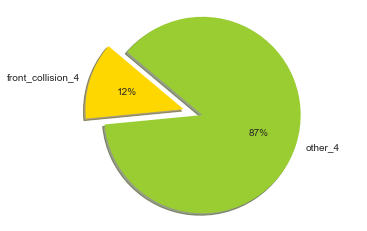

In [37]:
#slide 1
# Data to plot
labels = 'front_collision_4', 'other_4'
sizes = [df.iloc[1,1], df.iloc[0,1]]
colors = ['gold', 'yellowgreen']
explode = (0.2, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1d%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

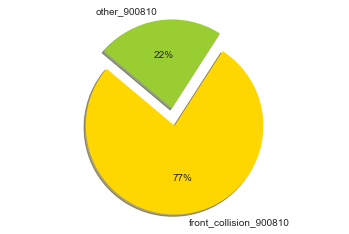

In [38]:
#slide 1
# Data to plot
labels = 'front_collision_900810', 'other_900810'
sizes = [df.iloc[0,0], df.iloc[1,0]]
colors = ['gold', 'yellowgreen']
explode = (0.2, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1d%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [82]:
#slide 1
'''
the folowing graph is comparing the precents of accident collisions and other types of accidents 
by accidents types harsh and fatal on road 900810.
accident collisions are bigger part of harsh and fatal accidents.
'''
#data_filtered_900810['front_collision'] = data_filtered_900810['accident_type'].replace(to_replace = {1:1,2:2,3:1,4:1,5:2,6:1,7:1,8:1,9:1,10:1,11:1,12:1,13:1,14:1,15:1,16:1,17:1,18:1,19:1,20:1})
fatal1 = (data_filtered_900810['accident_severity'] < 3)
df1 = data_filtered_900810[fatal1].groupby(['accident_severity','front_collision']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = True)
df.columns =['accident_severity','front_collision','count']
df

,accident_severity,front_collision,count
0,1,1,15
1,1,2,21
2,2,1,36
3,2,2,34


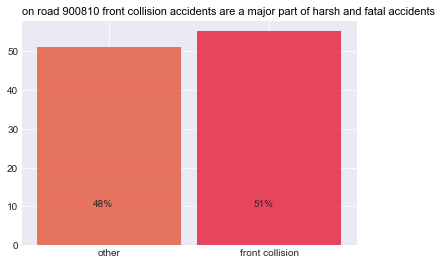

In [83]:
#slide 1
# Create bars
barWidth = 0.9
bars1 = df.iloc[0,2] + df.iloc[2,2]
bars2 = df.iloc[3,2] + df.iloc[1,2]
bars3 = df.drop(['accident_severity', 'front_collision'], axis = 1)
 
# The X position of bars
r1 = [1]
r2 = [2]
r3 = r1 + r2
 
# Create barplot
plt.bar(r1, bars1, width = barWidth, color = (0.9,0.4,0.3,0.9))
plt.bar(r2, bars2, width = barWidth, color = (0.9,0.2,0.3,0.9))
# Note: the barplot could be created easily. See the barplot section for other examples.

# Text below each barplot with a rotation at 90°
plt.xticks([r + barWidth for r in [0.1, 1.1]], ['other','front collision'])
 
# Create labels
label = ['48%','51%']
 
# Text of each barplot
for i in range(len(r3)):
    plt.text(x = r3[i]-0.1 , y = 10, s = label[i], size = 10)

plt.title("on road 900810 front collision accidents are a major part of harsh and fatal accidents", loc='left', fontsize=11, fontweight=0, color='k')

#Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)
 
# Show graphic
plt.show()

In [19]:
#slide 1
'''
the folowing graph is comparing the precents of accident collisions and other types of accidents 
by accidents types on Inter-urban roads across the country.
accident collisions relative part of harsh and fatal accidents is bigger than minor ones.
'''
data_filt_4 = road_type(data_filtered,4)

data_filt_4['front_collision'] = data_filt_4['accident_type'].replace(to_replace = {1:1,2:2,3:1,4:1,5:2,6:1,7:1,8:1,9:1,10:1,11:1,12:1,13:1,14:1,15:1,16:1,17:1,18:1,19:1,20:1})
df1 = data_filt_4.groupby(['accident_severity','front_collision']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = True)
df.columns =['accident_severity','front_collision','count']
print('graph 12')
df

graph 12


C:\Users\Chayne\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,accident_severity,front_collision,count
0,1,1,1106
1,1,2,693
2,2,1,3330
3,2,2,1743
4,3,1,111395
5,3,2,14411


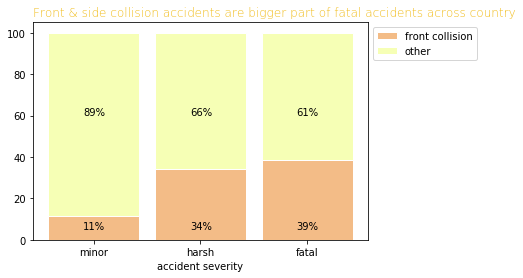

In [22]:
#slide 1
from matplotlib import rc
# Data
r = [0,1,2]
df1 = df.iloc[[5,3,1],2]
df1 = df1.reset_index(drop = True)
df2 = df.iloc[[4,2,0],2]
df2 = df2.reset_index(drop = True)
df1 = pd.DataFrame(df1)
df1.insert(1,'count all',df2)
raw_data = {'firstBars': df1.iloc[:,0], 'secondBars':df1.iloc[:,1]}
df3 = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df3['firstBars'], df3['secondBars'])]
greenBars = [i / j * 100 for i,j in zip(df3['firstBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df3['secondBars'], totals)]
 
# plot
barWidth = 0.85
names = ('minor','harsh','fatal')
# Create green Bars
plt.bar(r, greenBars, color='#f3bc87', edgecolor='white', width=barWidth, label="front collision")
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f6ffb5', edgecolor='white', width=barWidth, label="other")

# Custom x axis
plt.xticks(r, names)
plt.xlabel("accident severity")

# Text of each barplot
label1 = ['11%','34%','39%']
label2 = ['89%', '66%', '61%']

for i in range(len(r)):
    plt.text(x = r[i]-0.1 , y = 5, s = label1[i], size = 10)
    plt.text(x = r[i]-0.1 , y = 60, s = label2[i], size = 10)

# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

plt.title("Front & side collision accidents are bigger part of fatal accidents across country", loc='left', fontsize=12, fontweight=0, color=('#f1bc19'))
 
# Show graphic
plt.show()

In [43]:
#slide 2
'''
significant differences were found for 4 types of collision. road 900810 is mostly two-way road with no separation fence,
and front-to-side and front to front accident can happen more often.
the folowing graphs are presenting the The relative part of the inter-urban roads that is road 900810 and the 
relative part of road 900810's collision accidents of the inter-urban roads.
although road 900810 is less than 1% of the accidents of inter-urban roads, accident collisions on road 900810 are 2% of
the accident collisions of the inter-urban roads.
'''
data_filtered_900810['two_way'] = data_filtered_900810['one_lane'].replace(to_replace = {0:1,1:1,2:2,3:2,4:1,9:1})
df1 = data_filtered_900810.groupby(['two_way']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = False)
df.columns =['two_way_900810']

data_filtered_4['two_way'] = data_filtered_4['one_lane'].replace(to_replace = {0:1,1:1,2:2,3:2,4:1,9:1})
df2 = data_filtered_4.groupby(['two_way']).size()
table = pd.DataFrame(df2)
df_idx = table.reset_index(inplace = False)
df.insert(1,'two_way_4',table)

df

,two_way_900810,two_way_4
two_way,,
1,376,117859
2,320,14123


In [ ]:
data_filtered_900810['two_way'] = data_filtered_900810['one_lane'].replace(to_replace = {0:1,1:1,2:2,3:2,4:1,9:1})
df1 = data_filtered_900810.groupby(['two_way']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = False)
df.columns =['two_way_900810']

data_filtered_4['two_way'] = data_filtered_4['one_lane'].replace(to_replace = {0:1,1:1,2:2,3:2,4:1,9:1})
df2 = data_filtered_4.groupby(['two_way']).size()
table = pd.DataFrame(df2)
df_idx = table.reset_index(inplace = False)
df.insert(1,'two_way_4',table)

df, df.sum()

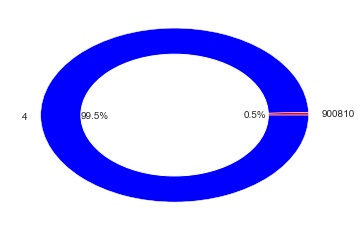

In [46]:
#slide 2
# prepare data
names='900810', '4'
sizes=[df.iloc[:,0].sum(),df.iloc[:,1].sum()]
 
# Create a circle for the center of the plot
my_circle=plt.Circle((0,0), 0.7, color='white')

# Give color names
plt.pie(sizes, labels=names,autopct='%1.1f%%', wedgeprops = { 'linewidth' : 0.5, 'edgecolor' : 'white' }, colors=['red','blue'])
p=plt.gcf()
p.gca().add_artist(my_circle)

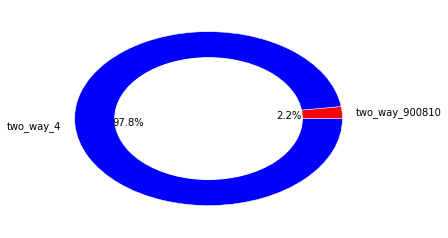

In [36]:
#slide 2
# prepare data
names='two_way_900810', 'two_way_4'
size=[df.iloc[1,0].sum(),df.iloc[1,1].sum()]
 
# Create a circle for the center of the plot
my_circle=plt.Circle((0,0), 0.7, color='white')

# Give color names
plt.pie(size, labels=names,autopct='%1.1f%%', wedgeprops = { 'linewidth' : 0.5, 'edgecolor' : 'white' }, colors=['red','blue'])
p=plt.gcf()
p.gca().add_artist(my_circle)


In [41]:
#slide 2
'''
significant differencess were found for 4 types of collision. road 900810 is mostly two-way road with no separation fence,
and front-to-side and front to front accident can happen more often.
the folowing graph is presenting the trends of accident collisions on a two-way road with a continuous lane seperator line
and non contiuous. and the average of collision accidents on these road types.
accident collisions trends are declining since 2017. There's no difference between continuous lane seperator line
and non contiuous on the average accidents count.
'''
data_filtered_900810['two_way'] = data_filtered_900810['one_lane'].replace(to_replace = {0:1,1:1,2:2,3:3,4:1,9:1})
two_way = (data_filtered_900810['two_way'] > 1)
df1 = data_filtered_900810[two_way].groupby(['accident_year','one_lane']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = True)
df.columns =['year','lane','count']
df = pd.pivot_table(df, values='count', index=['year'],
                    columns=['lane'], aggfunc=np.sum)
df.columns =['continuous','not continuous']
df_idx = df.reset_index(inplace = True)

two_way_headon = (data_filtered_900810['two_way'] > 1) & (data_filtered_900810['front_collision'] == 2)
df1 = data_filtered_900810[two_way].groupby(['accident_year','two_way', 'front_collision']).size()
df1 = pd.DataFrame(df1)
df_idx = df1.reset_index(inplace = True)
df1 = df1.drop(['front_collision', 'two_way'], axis = 1)
df1 = df1.groupby(['accident_year']).sum()
df1.columns = ['front_collision_count']
df_idx = df1.reset_index(inplace = True)
df1['front_collision_average'] = df1.front_collision_count/2
df1 = pd.DataFrame(df1)
df.insert(3,'front collision average',df1.front_collision_average)

df

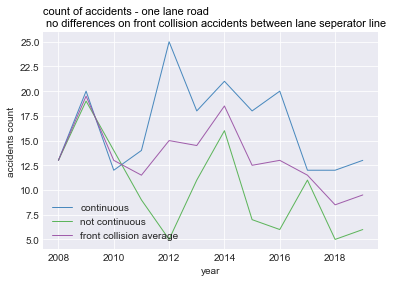

In [38]:
#slide 2
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('year',axis = 1):
    num+=1
    plt.plot(df.iloc[:,0], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc='lower left')
 
# Add titles
plt.title("count of accidents - one lane road \n no differences on front collision accidents between lane seperator line", loc='left', fontsize=11, fontweight=0, color='k')
plt.xlabel("year")
plt.ylabel("accidents count")

Text(0,1,'count of accidents')

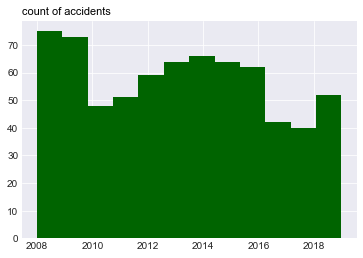

In [53]:
#slide 3
data_filtered_900810['accident_year'].hist(bins = 12, range =(2008, 2019), color = 'darkgreen')
plt.title("count of accidents", loc='left', fontsize=11, fontweight=0, color='k')

In [97]:
#slide 3
'''
significant differencess were found for harsh accident type.
the folowing graph is comparing the percents of improvement for accidents count for road 900810 
between every period of time by accident severity.
there is an improvement for minor and fatal accidents, alongside no change in harsh accidents(after a decline of 0.31 on years 2011-14).
'''
dataf_08_10_900810 = data_years(data_filtered_900810, 2008, 2010)
dataf_11_13_900810 = data_years(data_filtered_900810, 2011, 2013)
dataf_14_16_900810 = data_years(data_filtered_900810, 2014, 2016)
dataf_17_19_900810 = data_years(data_filtered_900810, 2017, 2019)
#caculating the differences between 4 periods 
column = 'accident_severity'
print('graph 9')
df1 = (dataf_08_10_900810.groupby(column).size()-(dataf_11_13_900810.groupby(column).size())) / (dataf_08_10_900810.groupby(column).size()).round(2) 
df2 = ((dataf_11_13_900810.groupby(column).size() - (dataf_14_16_900810.groupby(column).size())) / ( dataf_11_13_900810.groupby(column).size())).round(2) 
df3 =(dataf_14_16_900810.groupby(column).size() - (dataf_17_19_900810.groupby(column).size())) / (dataf_14_16_900810.groupby(column).size()).round(2)
df1, df2, df3

graph 9


(accident_severity
 1    0.125000
 2    0.434783
 3    0.066667
 dtype: float64, accident_severity
 1   -1.00
 2   -0.31
 3   -0.05
 dtype: float64, accident_severity
 1    0.50000
 2    0.00000
 3    0.31677
 dtype: float64)

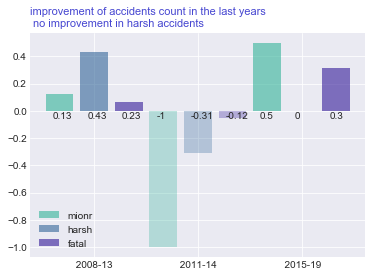

In [98]:
#slide 3
 
# Create bars
barWidth = 0.8
bars1 = df1[:]
bars2 = df2[:]
bars3 = df3[:]
bars4 = bars1 + bars2 + bars3
 
# The X position of bars
r1 = [1,2,3]
r2 = [4,5,6]
r3 = [7,8,9]
r4 = r1 + r2 + r3
 
# Create barplot
plt.bar(r1[0], bars1[1], width = barWidth, color = (0.2,0.7,0.6,0.6))
plt.bar(r1[1], bars1[2], width = barWidth, color = (0.2,0.4,0.6,0.6))
plt.bar(r1[2], bars1[3], width = barWidth, color = (0.2,0.1,0.6,0.6))
plt.bar(r2[0], bars2[1], width = barWidth, color = (0.2,0.7,0.6,0.3))
plt.bar(r2[1], bars2[2], width = barWidth, color = (0.2,0.4,0.6,0.3))
plt.bar(r2[2], bars2[3], width = barWidth, color = (0.2,0.1,0.6,0.3))
plt.bar(r3[0], bars3[1], width = barWidth, color = (0.2,0.7,0.6,0.6), label='mionr')
plt.bar(r3[1], bars3[2], width = barWidth, color = (0.2,0.4,0.6,0.6), label='harsh')
plt.bar(r3[2], bars3[3], width = barWidth, color = (0.2,0.1,0.6,0.6), label='fatal')
# Note: the barplot could be created easily. See the barplot section for other examples.
 
# Create legend
plt.legend()

# Text below each barplot with a rotation at 90°
plt.xticks([r + barWidth*5 for r in [-2, 1, 4]], [' 2008-13 ', ' 2011-14 ', '  2015-19 '])
 
# Create labels
label = ['0.13', '0.43', '0.23', '-1', '-0.31', '-0.12', '0.5', '0', '0.3']
 
# Text on the top of each barplot
for i in range(len(r4)):
    plt.text(x = r4[i]-0.2 , y = -0.06, s = label[i], size = 10)

#Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)
 
plt.title("improvement of accidents count in the last years\n no improvement in harsh accidents", loc='left', fontsize=11, fontweight=0, color=(0.2,0.2,0.8,0.9))
# Show graphic
plt.show()

In [99]:
#slide 3
'''
significant differencess were found for injury severity harsh and deadly. 
the folowing graph is comparing the average accidents count for road 900810 
between every period of time by injury severity.
the minor injured average has declined over the years, unlike the harsh and deadly injured.
'''
data_08_10_900810 = data_years(data_900810, 2008, 2010)
data_11_13_900810 = data_years(data_900810, 2011, 2013)
data_14_16_900810 = data_years(data_900810, 2014, 2016)
data_17_19_900810 = data_years(data_900810, 2017, 2019)
print('graph 14')
df1 = data_08_10_900810.groupby('injury_severity').size()/3 
df2 = data_11_13_900810.groupby('injury_severity').size()/3
df3 = data_14_16_900810.groupby('injury_severity').size()/3
df4 = data_17_19_900810.groupby('injury_severity').size()/3
df1, df2, df3, df4

graph 14


(injury_severity
 0     27.000000
 1    164.333333
 2     14.666667
 3      4.000000
 dtype: float64, injury_severity
 0     32.333333
 1    129.000000
 2     13.666667
 3      4.000000
 dtype: float64, injury_severity
 0     31.000000
 1    132.000000
 2     12.333333
 3      6.000000
 dtype: float64, injury_severity
 0    28.333333
 1    90.666667
 2    11.333333
 3     4.333333
 dtype: float64)

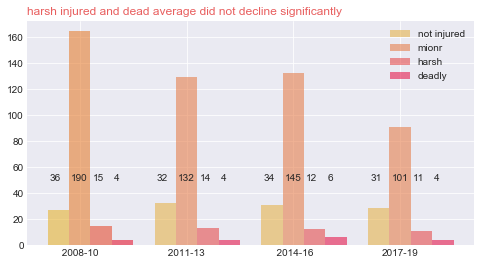

In [100]:
#slide 3
# Create bars
barWidth = 0.5
bars1 = df1[:]
bars2 = df2[:]
bars3 = df3[:]
bars4 = df4[:]
bars5 = bars1 + bars2 + bars3 +bars4
 
# The X position of bars
r1 = [0.5,1,1.5,2]
r2 = [3,3.5,4,4.5]
r3 = [5.5,6,6.5,7]
r4 = [8,8.5,9,9.5]
r5 = r1 + r2 + r3 +r4

#figure size
plt.figure(figsize=(8,4))

# Create barplot
plt.bar(r1[0], bars1[0], width = barWidth, color = (0.9,0.7,0.2,0.6))
plt.bar(r1[1], bars1[1], width = barWidth, color = (0.9,0.5,0.2,0.6))
plt.bar(r1[2], bars1[2], width = barWidth, color = (0.9,0.3,0.2,0.6))
plt.bar(r1[3], bars1[3], width = barWidth, color = (0.9,0.1,0.2,0.6))
plt.bar(r2[0], bars2[0], width = barWidth, color = (0.9,0.7,0.3,0.6))
plt.bar(r2[1], bars2[1], width = barWidth, color = (0.9,0.5,0.3,0.6))
plt.bar(r2[2], bars2[2], width = barWidth, color = (0.9,0.3,0.3,0.6))
plt.bar(r2[3], bars2[3], width = barWidth, color = (0.9,0.1,0.3,0.6))
plt.bar(r3[0], bars3[0], width = barWidth, color = (0.9,0.7,0.3,0.6))
plt.bar(r3[1], bars3[1], width = barWidth, color = (0.9,0.5,0.3,0.6))
plt.bar(r3[2], bars3[2], width = barWidth, color = (0.9,0.3,0.3,0.6))
plt.bar(r3[3], bars3[3], width = barWidth, color = (0.9,0.1,0.3,0.6))
plt.bar(r4[0], bars4[0], width = barWidth, color = (0.9,0.7,0.3,0.6),label='not injured')
plt.bar(r4[1], bars4[1], width = barWidth, color = (0.9,0.5,0.3,0.6), label='mionr')
plt.bar(r4[2], bars4[2], width = barWidth, color = (0.9,0.3,0.3,0.6), label='harsh')
plt.bar(r4[3], bars4[3], width = barWidth, color = (0.9,0.1,0.3,0.6), label='deadly')
 
# Create legend
plt.legend(loc='upper right')

# Text below each barplot
plt.xticks([r + barWidth*5 for r in [-1.5, 1, 3.5, 6]], [' 2008-10 ', ' 2011-13 ', '  2014-16 ', '2017-19'])
 
# Create labels
label = ['36', '190', '15', '4', '32', '132', '14', '4', '34', '145','12', '6', '31', '101', '11' , '4']
 
# Text on the top of each barplot
for i in range(len(r5)):
    plt.text(x = r5[i]-0.2 , y = 50, s = label[i], size = 10)

#Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)
 
plt.title("harsh injured and dead average did not decline significantly", loc='left', fontsize=12, fontweight=0, color=(0.9,0.3,0.3,0.9))
# Show graphic
plt.show()

In [101]:
#slide 4
'''
significant differencess were found for injury severity harsh. 
the folowing graph is presenting the trends of injury severity types along the years 2008-19.
harsh and non injured involved in accident increased in the last two years while minor and deadly decreased.
'''
df1 = data_900810.groupby(['accident_year', 'injury_severity']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = True)
df.columns =['year','injury_severity','count']
print('graph 13')
df = pd.pivot_table(df, values='count', index=['year'],
                    columns=['injury_severity'], aggfunc=np.sum)

df

graph 13


injury_severity,0,1,2,3
year,,,,
2008,33,167,9,2
2009,25,179,24,7
2010,23,147,11,3
2011,35,131,10,7
2012,28,126,8,2
2013,34,130,23,3
2014,30,135,18,10
2015,29,162,6,3
2016,34,99,13,5


Text(0,0.5,'accidents count ')

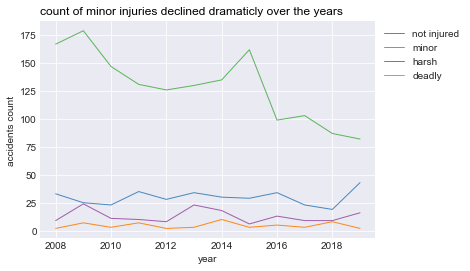

In [102]:
#slide 4
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for i in range(0,4):
    num+=1
    plt.plot(df.index, df[i], marker='', color=palette(num), linewidth=1, alpha=0.9, label='year')

# Add legend
plt.legend(labels = ['not injured', 'minor', 'harsh', 'deadly'], loc='upper left', bbox_to_anchor=(1,1), ncol=1)
 

# Add titles
plt.title("count of minor injuries declined dramaticly over the years", loc='left', fontsize=12, fontweight=0, color='k')
plt.xlabel("year")
plt.ylabel("accidents count ")

In [177]:
#slide 4
'''
significant differencess were found for severly injured.
the folowing graph is comparing the percents of injures severity of those involved in accidents 
between road 900810 to inter-urban roads.
there are more severly injured in percentage on road 900810 than is other on inter-urban roads.
'''
df1 = data_900810.groupby(['injury_severity']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = False)
df.columns =['injury_severity_900810']

df2 = data_4.groupby(['injury_severity']).size()
table = pd.DataFrame(df2)
df_idx = table.reset_index(inplace = False)
df.insert(1,'injury_severity_4',table)
print('graph 8')
df = df.apply(lambda x: x/x.sum())
df

graph 8


,injury_severity_900810,injury_severity_4
injury_severity,,
0,0.173857,0.319517
1,0.735116,0.654786
2,0.067299,0.019823
3,0.023727,0.005874


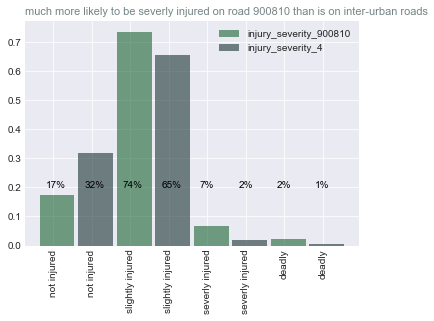

In [179]:
#slide 4 
# Create bars
barWidth = 0.9
bars1 = df.iloc[0,:]
bars2 = df.iloc[1,:]
bars3 = df.iloc[2,:]
bars4 = df.iloc[3,:]
bars5 = bars1 + bars2 + bars3 +bars4
 
# The X position of bars
r1 = [1,2]
r2 = [3,4]
r3 = [5,6]
r4 = [7,8]
r5 = r1 + r2 + r3 + r4 
 
# Create barplot
plt.bar(r1[0], bars1[0], width = barWidth, color = (0.1,0.4,0.2,0.6))
plt.bar(r1[1], bars1[1], width = barWidth, color = (0.1,0.2,0.2,0.6))
plt.bar(r2[0], bars2[0], width = barWidth, color = (0.1,0.4,0.2,0.6))
plt.bar(r2[1], bars2[1], width = barWidth, color = (0.1,0.2,0.2,0.6))
plt.bar(r3[0], bars3[0], width = barWidth, color = (0.1,0.4,0.2,0.6))
plt.bar(r3[1], bars3[1], width = barWidth, color = (0.1,0.2,0.2,0.6))
plt.bar(r4[0], bars4[0], width = barWidth, color = (0.1,0.4,0.2,0.6), label='injury_severity_900810')
plt.bar(r4[1], bars4[1], width = barWidth, color = (0.1,0.2,0.2,0.6), label='injury_severity_4')
# Note: the barplot could be created easily. See the barplot section for other examples.
 
# Create legend
plt.legend()

# Text below each barplot with a rotation at 90°
plt.xticks([r + barWidth for r in range(len(r5))], ['not injured', 'not injured', 'slightly injured', 'slightly injured', 'severly injured', 'severly injured', 'deadly', 'deadly'], rotation=90)
 
# Create labels
label = ['17%', '32%', '74%', '65%', '7%', '2%', '2%', '1%']
 
# Text on the top of each barplot
for i in range(len(r5)):
    plt.text(x = r5[i]-0.3 , y = 0.2, s = label[i], size = 10, color = 'k')
#title 
plt.title("much more likely to be severly injured on road 900810 than is on inter-urban roads", loc='left', fontsize=11, fontweight=0, color=(0.1,0.2,0.2,0.6))
    
#Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)

# Show graphic
plt.show()

Text(0,1,'count of accidents on inter urban roads by day')

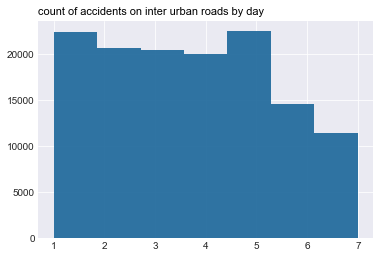

In [68]:
#slide 5
data_filtered_4['day_in_week'].hist(bins = 7, range =(1, 7), color = (0.1,0.4,0.6,0.9))
plt.title("count of accidents on inter urban roads by day", loc='left', fontsize=11, fontweight=0, color='k')

Text(0,1,'count of accidents on road 900810 by day')

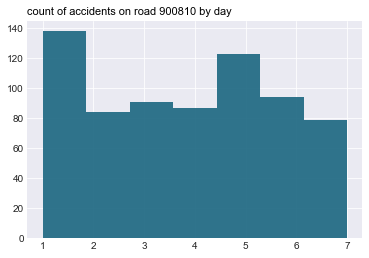

In [64]:
#slide 5
data_filtered_900810['day_in_week'].hist(bins = 7, range =(1, 7), color = (0.1,0.4,0.5,0.9))
plt.title("count of accidents on road 900810 by day", loc='left', fontsize=11, fontweight=0, color='k')

In [165]:
#slide 5
'''
significant differencess were found for sunday saterday and holiday.
focused on the holiday days as road 900810 is nearby trip sites.
the folowing graph is comparing the percents between road 900810 to inter-urban roads count of accident on weekdays, and holidays.
holidays are more prone to accidents on road 900810 than other inter-urban roads.
'''
data_filtered_900810['holiday'] = data_filtered_900810['day_type'].replace(to_replace = {0:1,1:3,2:2,3:2,4:1})
data_filtered_900810['holiday'] = data_filtered_900810['day_in_week'].replace(to_replace = {0:1,1:1,2:1,3:1,4:1,5:1,6:2,7:3})
df1 = data_filtered_900810.groupby(['holiday']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = False)
df.columns =['holiday_900810']

data_filtered_4['holiday'] = data_filtered_4['day_type'].replace(to_replace = {0:1,1:3,2:2,3:2,4:1})
data_filtered_4['holiday'] = data_filtered_4['day_in_week'].replace(to_replace = {0:1,1:1,2:1,3:1,4:1,5:1,6:2,7:3})
df2 = data_filtered_4.groupby(['holiday']).size()
table = pd.DataFrame(df2)
df_idx = table.reset_index(inplace = False)
df.insert(1,'holiday_4',table)

df

,holiday_900810,holiday_4
holiday,,
1,523,105998
2,94,14536
3,79,11448


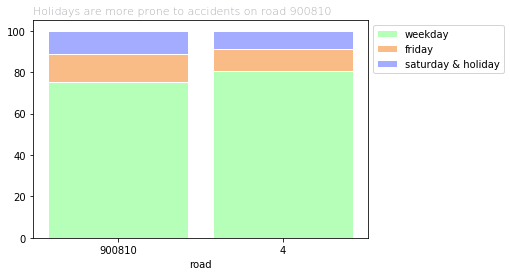

In [166]:
from matplotlib import rc
# Data
r = [0,1]
raw_data = {'greenBars': df.iloc[0,:], 'orangeBars': df.iloc[1,:],'blueBars': df.iloc[2,:]}
df1 = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df1['greenBars'], df1['orangeBars'], df1['blueBars'])]
greenBars = [i / j * 100 for i,j in zip(df1['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df1['orangeBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df1['blueBars'], totals)]
 
# plot
barWidth = 0.85
names = ('900810','4')
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label="weekday")
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth, label="friday")
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth, label="saturday & holiday")

# Custom x axis
plt.xticks(r, names)
plt.xlabel("road")
 
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

plt.title("Holidays are more prone to accidents on road 900810", loc='left', fontsize=11, fontweight=0, color='#a9aaaf')

 
# Show graphic
plt.show()

In [185]:
df1 = data_filtered_900810.groupby(['accident_type', 'weather']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = False)
df.columns =['900810']
df = pd.pivot_table(df, values='900810', index=['weather'],
                    columns=['accident_type'], aggfunc=np.sum)
#df.columns =['weekday','friday', 'saturday & holiday']
df.apply(lambda x: x/x.sum()).round(2)

accident_type,1,2,3,4,5,6,7,8,9,10,11,12,15,18,19,20
weather,,,,,,,,,,,,,,,,
1,0.43,0.75,0.21,0.53,0.78,1.0,0.5,0.27,0.35,0.48,0.16,NaN,NaN,0.5,0.24,1.0
2,0.04,0.06,0.04,NaN,0.06,NaN,NaN,0.02,0.05,0.10,0.09,NaN,NaN,0.5,NaN,NaN
3,NaN,NaN,NaN,0.03,0.03,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.02,NaN,NaN,NaN,NaN,NaN
9,0.54,0.19,0.75,0.44,0.11,NaN,0.5,0.71,0.61,0.40,0.73,1.0,1.0,NaN,0.76,NaN


In [200]:
df1 = data_filtered_900810.groupby(['holiday', 'age_group']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = False)
df.columns =['holiday_900810']
df = pd.pivot_table(df, values='holiday_900810', index=['age_group'],
                    columns=['holiday'], aggfunc=np.sum)
df.columns =['weekday','friday', 'saturday & holiday']
df.apply(lambda x: x/x.sum())

,weekday,friday,saturday & holiday
age_group,,,
1,0.013384,0.010638,NaN
2,0.011472,0.010638,0.012658
3,0.007648,0.010638,0.012658
4,0.040153,0.063830,0.063291
5,0.118547,0.223404,0.151899
6,0.131931,0.170213,0.151899
7,0.128107,0.063830,0.113924
8,0.105163,0.127660,0.101266
9,0.091778,0.085106,0.126582


In [202]:
df = chi_test(data_4, data_900810, 'age_group')
chi_sig(df), df, year_diff(data_900810,'age_group')

((    column1_per  column2_per
  0     -0.006695     1.168794
  1     -0.016619     2.901182
  2     -0.009617     1.678960
  3     -0.014823     2.587707
  4     -0.022721     3.966430
  5      0.002716    -0.474232
  6      0.004149    -0.724350
  7      0.003916    -0.683688
  8      0.001297    -0.226478
  9     -0.005298     0.924823
  10    -0.002909     0.507801
  11    -0.002058     0.359338
  12     0.003670    -0.640662
  13     0.000566    -0.098818
  14    -0.000867     0.151300
  15    -0.000886     0.154610
  16     0.000488    -0.085106
  17    -0.001481     0.258629
  18     0.067165   -11.725296, column1_per    18
  column2_per     4
  dtype: int64),            column1  column2
 age_group                  
 1             7706       69
 2             7034      102
 3             6334       72
 4            16752      151
 5            40088      314
 6            42088      231
 7            36558      194
 8            31867      168
 9            26504      147
 10   

In [24]:
#slide 6
'''
significant differencess were found for buses and trucks.
the folowing graph is presenting the average number of vehicles that were involved in an accident for a year.
trucks and buses have a high average of accident involvement per year.
'''
data_900810['vehicle_type'] = data_900810['involve_vehicle_type'].replace(to_replace = {0:1,1:1,2:2,3:3,4:2,5:3,6:3,7:3})
df1 = data_900810.groupby(['vehicle_type']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = False)
df.columns =['vehicle_type_900810']

data_4['vehicle_type'] = data_4['involve_vehicle_type'].replace(to_replace = {0:1,1:1,2:2,3:3,4:2,5:3,6:3,7:3,8:3,9:3,10:3})
df2 = data_4.groupby(['vehicle_type']).size()
table = pd.DataFrame(df2)
df_idx = table.reset_index(inplace = False)
df.insert(1,'vehicle_type_4',table)
print('graph 6')
df = df.apply(lambda x: x/x.sum()).round(2)
df

graph 6


,vehicle_type_900810,vehicle_type_4
vehicle_type,,
1.0,0.67,0.73
2.0,0.25,0.17
3.0,0.08,0.11


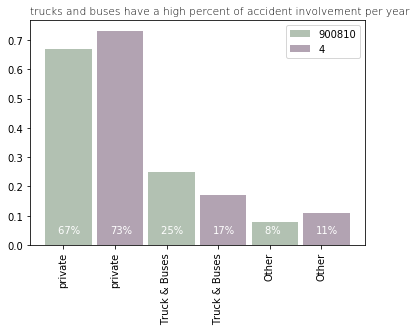

In [25]:
# Create bars
barWidth = 0.9
bars1 = df.iloc[0,:]
bars2 = df.iloc[1,:]
bars3 = df.iloc[2,:]
#bars5 = df.drop(0)
 
# The X position of bars
r1 = [1,2]
r2 = [3,4]
r3 = [5,6]
r4 = r1 + r2 + r3 
 
# Create barplot
plt.bar(r1[0], bars1[0], width = barWidth, color = (0.5,0.6,0.5,0.6))
plt.bar(r1[1], bars1[1], width = barWidth, color = (0.5,0.4,0.5,0.6))
plt.bar(r2[0], bars2[0], width = barWidth, color = (0.5,0.6,0.5,0.6))
plt.bar(r2[1], bars2[1], width = barWidth, color = (0.5,0.4,0.5,0.6))
plt.bar(r3[0], bars3[0], width = barWidth, color = (0.5,0.6,0.5,0.6), label = '900810')
plt.bar(r3[1], bars3[1], width = barWidth, color = (0.5,0.4,0.5,0.6), label = '4')
# Note: the barplot could be created easily. See the barplot section for other examples.
 
# Create legend
plt.legend(loc = 'upper right')

# Text below each barplot with a rotation at 90°
plt.xticks([r + barWidth for r in range((6))], ['private', 'private', 'Truck & Buses', 'Truck & Buses', 'Other', 'Other'], rotation=90)
 
# Create labels
label = ['67% ', '73%','25% ', '17%', '8% ', '11%']
 
# Text on the top of each barplot
for i in range(len(r4)):
    plt.text(x = r4[i]-0.2 , y = 0.04, s = label[i], size = 10, color = 'w')

#Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)

#title
plt.title("trucks and buses have a high percent of accident involvement", loc='left', fontsize=10.5, fontweight=0, color='k')

    # Show graphic
plt.show()

In [157]:
#slide 6
data_900810['Poor lighting'] = data_900810['road_light'].replace(to_replace = {1:0,2:0,3:0,4:1,5:1,6:0,7:0,8:0,9:0,10:0,11:0})
df1 = data_900810.groupby(['Poor lighting','vehicle_type']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = True)
df.columns =['Poor lighting','vehicle_type','count']
df = pd.pivot_table(df, values='count', index=['Poor lighting'],
                    columns=['vehicle_type'], aggfunc=np.sum)
df.columns =['private','Trucks & Buses', 'Other']
#df_idx = df.reset_index(inplace = True)
df

,private,Trucks & Buses,Other
Poor lighting,,,
0,1155,409,148
1,240,114,16


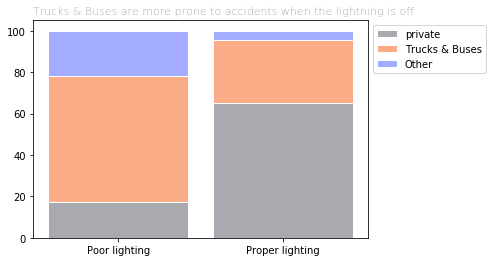

In [158]:
from matplotlib import rc
# Data
r = [0,1]
raw_data = {'firstBars': [115,240], 'secondBars': [409,114],'thirdBars': [148, 16]}
df1 = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df1['firstBars'], df1['secondBars'], df1['thirdBars'])]
greenBars = [i / j * 100 for i,j in zip(df1['firstBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df1['secondBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df1['thirdBars'], totals)]
 
# plot
barWidth = 0.85
names = ('Poor lighting','Proper lighting')
# Create green Bars
plt.bar(r, greenBars, color='#a9aaaf', edgecolor='white', width=barWidth, label="private")
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9ac86', edgecolor='white', width=barWidth, label="Trucks & Buses")
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth, label="Other")

# Custom x axis
plt.xticks(r, names)

 
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

plt.title("Trucks & Buses are more prone to accidents when the lightning is off", loc='left', fontsize=11, fontweight=0, color='#a9aaaf')

 
# Show graphic
plt.show()

In [174]:
#can replace third graph on slide 3
'''
significant differencess were found for medium and harsh medical types.
the folowing graph is comparing the percents of medical types of those involved in accidents
between road 900810 to inter-urban roads.
medium and harsh have a high precentage of medical type of involved in accidents on road 900810.
'''
df1 = data_900810.groupby(['medical_type']).size()
df = pd.DataFrame(df1)
df_idx = df.reset_index(inplace = False)
df.columns =['medical_type_900810']

df2 = data_4.groupby(['medical_type']).size()
table = pd.DataFrame(df2)
df_idx = table.reset_index(inplace = False)
df.insert(1,'medical_type_4',table)
print('graph 7')
df = df.apply(lambda x: x/x.sum())
df

graph 7


,medical_type_900810,medical_type_4
medical_type,,
0.0,0.000000,0.007336
1.0,0.394444,0.601056
2.0,0.194444,0.177293
3.0,0.227778,0.100644
4.0,0.183333,0.113671


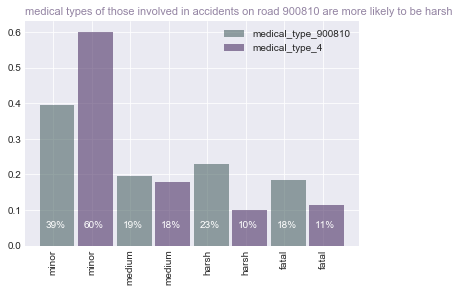

In [176]:
# Create bars
barWidth = 0.9
bars1 = df.iloc[1,:]
bars2 = df.iloc[2,:]
bars3 = df.iloc[3,:]
bars4 = df.iloc[4,:]
bars5 = df.drop(0)
 
# The X position of bars
r1 = [1,2]
r2 = [3,4]
r3 = [5,6]
r4 = [7,8]
r5 = r1 + r2 + r3 + r4 
 
# Create barplot
plt.bar(r1[0], bars1[0], width = barWidth, color = (0.3,0.4,0.4,0.6))
plt.bar(r1[1], bars1[1], width = barWidth, color = (0.3,0.2,0.4,0.6))
plt.bar(r2[0], bars2[0], width = barWidth, color = (0.3,0.4,0.4,0.6))
plt.bar(r2[1], bars2[1], width = barWidth, color = (0.3,0.2,0.4,0.6))
plt.bar(r3[0], bars3[0], width = barWidth, color = (0.3,0.4,0.4,0.6))
plt.bar(r3[1], bars3[1], width = barWidth, color = (0.3,0.2,0.4,0.6))
plt.bar(r4[0], bars4[0], width = barWidth, color = (0.3,0.4,0.4,0.6), label='medical_type_900810')
plt.bar(r4[1], bars4[1], width = barWidth, color = (0.3,0.2,0.4,0.6), label='medical_type_4')
# Note: the barplot could be created easily. See the barplot section for other examples.
 
# Create legend
plt.legend(loc = 'upper right')

# Text below each barplot with a rotation at 90°
plt.xticks([r + barWidth for r in range((8))], ['minor', 'minor', 'medium', 'medium', 'harsh', 'harsh', 'fatal', 'fatal'], rotation=90)
 
# Create labels
label = ['39%', '60%', '19%', '18%', '23%', '10%', '18%', '11%']
 
# Text on the top of each barplot
for i in range(len(r5)):
    plt.text(x = r5[i]-0.3 , y = 0.05, s = label[i], size = 10, color = 'w')

#Adjust the margins
plt.subplots_adjust(bottom= 0.2, top = 0.98)

#title
plt.title("medical types of those involved in accidents on road 900810 are more likely to be harsh", loc='left', fontsize=11, fontweight=0, color=(0.3,0.2,0.4,0.6))
 
# Show graphic
plt.show()